In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# INTRODUCTION

The goal of this task is to classify e-mails into 2 classes (spam or not spam). Spam e-mails are labeled as 'Result' equals to 1 and non spam e-mails are labeled as 'Result' equals 0.

The obtained dataset has training and testing set which consist of 3620 and 1552 e-mails respectively. The dataset has only Bag of Words features which is basically number of occurences of each words at each e-mails. 

There are some problems that need to be solved in order to make a good classification. Some major problems :
- All of the words are labeled as word-1 to word-40, no information about what kind of words they possibly are
- Imbalanced class
- Outliers
- Missing values

In this notebook all of the problems are going to be treated step by step so machine learning model(s) are able to make an accurate prediction.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import math

In [3]:
train = pd.read_csv('../input/datmin-joints-2020/train_data.csv')
train['total_words'] = train.iloc[:, 1:41].sum(axis = 1)
train_original = pd.read_csv('../input/datmin-joints-2020/train_data.csv')
test = pd.read_csv('../input/datmin-joints-2020/test_data.csv')
test_original = pd.read_csv('../input/datmin-joints-2020/test_data.csv')
sample_submission = pd.read_csv('../input/datmin-joints-2020/sample_submission.csv')

In [4]:
train_original.head()

,id,word-1,word-2,word-3,word-4,word-5,word-6,word-7,word-8,word-9,...,word-32,word-33,word-34,word-35,word-36,word-37,word-38,word-39,word-40,Result
0,1,5,0.0,0.0,0.0,0,0.0,0.0,1,0,...,0.0,0,0.0,0,0.0,0.0,0,0,0,0
1,2,117,1.0,4.0,3.0,NaN,5.0,2.0,9,19,...,3.0,13,9.0,15,3.0,NaN,13,3,1,0
2,3,30,1.0,1.0,5.0,8,3.0,2.0,2,2,...,1.0,5,1.0,1,1.0,0.0,0,0,0,0
3,4,3,0.0,0.0,0.0,0,0.0,0.0,0,1,...,0.0,NaN,0.0,0,0.0,0.0,NaN,0,0,0
4,5,263,6.0,8.0,8.0,NaN,26.0,1.0,21,35,...,10.0,NaN,5.0,49,26.0,24.0,23,4,24,1


In [5]:
print(train.shape[0])
print(test.shape[0])

3620
1552


FEATURES

In [6]:
train_original.columns

Index(['id', 'word-1', 'word-2', 'word-3', 'word-4', 'word-5', 'word-6',
       'word-7', 'word-8', 'word-9', 'word-10', 'word-11', 'word-12',
       'word-13', 'word-14', 'word-15', 'word-16', 'word-17', 'word-18',
       'word-19', 'word-20', 'word-21', 'word-22', 'word-23', 'word-24',
       'word-25', 'word-26', 'word-27', 'word-28', 'word-29', 'word-30',
       'word-31', 'word-32', 'word-33', 'word-34', 'word-35', 'word-36',
       'word-37', 'word-38', 'word-39', 'word-40', 'Result'],
      dtype='object')

Y DISTRIBUTION PLOT (IMBALANCED CLASS)

([<matplotlib.axis.XTick at 0x7f3969c561d0>,
 [Text(0, 0, 'non_spam (0)'), Text(0, 0, 'spam (1)')])

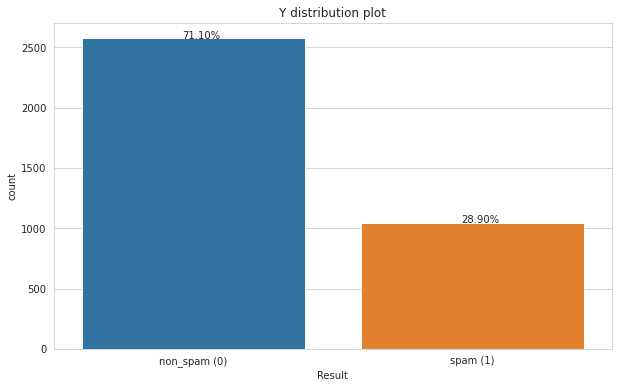

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize = [10, 6])
xy_initial_countplot = sns.countplot(train['Result'])
values = [train[train['Result'] == 0].shape[0], 
          train[train['Result'] == 1].shape[0]]
#train[train['Result'] == 0].shape[0]*100/train.shape[0]
for index, value in enumerate(values) :
    plt.text(index-.04, value, str('%.2f'%(value*100/train.shape[0]) + '%'))
plt.title('Y distribution plot')
plt.xticks([0, 1], ['non_spam (0)', 'spam (1)'])

MISSING VALUES

In [8]:
print('number of rows contain missing values in training set = {missing}'.format(missing = train[train.isnull().any(axis = 1)].shape[0]))
print('number of rows contain missing values in testing set = {missing}'.format(missing = test[test.isnull().any(axis = 1)].shape[0]))

number of rows contain missing values in training set = 502
number of rows contain missing values in testing set = 590


# data cleaning

All of the words frequency in the dataset are actually string so it needs to be transformed into numerical scale. Apart from that, there are also some problems that need cleaning because the occurence of some weird strings.

REMOVING '`' CHARACTER

In [9]:
for column in train.columns[1:-1] :
    if train[column].dtype == 'O' :
        train[column] = train[column].str.replace('`', '')        

TRANSFORMING ROWS THAT CONTAIN NON-NUMERIC ELEMENTS INTO Nan

In [10]:
index = []
checking_dict = {}
for var in tqdm(train.columns[1:-2]) :
    for row, ID in zip(train[var], train['id']) :
        if (pd.isna(row) == True) :
            next
        else :
            if type(row) == np.float :
                next
            elif (row.isdigit() == False) :
                index.append(ID)
                checking_dict.update({str(ID) : [var, row]})
                train.loc[train['id'] == ID, var] = np.nan
                #train.loc[train['id'] == 3582, 'word-1'] = np.nan
            else:
                next
checking_dict
#train = train[~train['id'].isin(list(pd.DataFrame(index).iloc[:,0].unique()))]
#train = train.astype('float')
#train.shape

{'3582': ['word-1', 'a'],
 '180': ['word-5', '4+F2185'],
 '195': ['word-5', '11h'],
 '513': ['word-5', 'a'],
 '338': ['word-8', 'a'],
 '1652': ['word-8', 'a'],
 '572': ['word-9', ''],
 '662': ['word-11', '\\'],
 '347': ['word-13', 'a'],
 '1036': ['word-13', 'a'],
 '2259': ['word-17', 'a'],
 '1006': ['word-18', 'a'],
 '2870': ['word-18', '\\'],
 '2622': ['word-27', '['],
 '1813': ['word-28', 'a'],
 '256': ['word-30', 'a'],
 '2596': ['word-33', 'a'],
 '1938': ['word-40', 'a']}

Those are the ids that contain weird strings in the training set that is mentioned before.

In [11]:
index_test = []
checking_dict_test = {}
for var in tqdm(test.columns[1:]) :
    for row, ID in zip(test[var], test['id']) :
        if (pd.isna(row) == True) :
            next
        else :
            if type(row) == np.float :
                next
            elif (row.isdigit() == False) :
                index_test.append(ID)
                checking_dict_test.update({str(ID) : [var, row]})
                test.loc[test['id'] == ID, var] = np.nan
                #test.loc[test['id'] == 3582, 'word-1'] = np.nan
            else:
                next
checking_dict_test
#test = test[~test['id'].isin(list(pd.DataFrame(index_test).iloc[:,0].unique()))]
#test = test.astype('float')
#test.shape

{}

- no input error on testing set so no transformation.
- taking some sample from those rows to check if the transformation is complete.

In [12]:
print(train.loc[train['id'] == 3582, 'word-1'])
print(train.loc[train['id'] == 2870, 'word-18'])
print(train.loc[train['id'] == 1938, 'word-40'])

3581    NaN
Name: word-1, dtype: object
2869    NaN
Name: word-18, dtype: object
1937    NaN
Name: word-40, dtype: object


transformation was success. next step, changing dataframe type into float

In [13]:
train = train.astype(float)
test = test.astype(float)

Text(0.5, 1.0, 'skewness for each features')

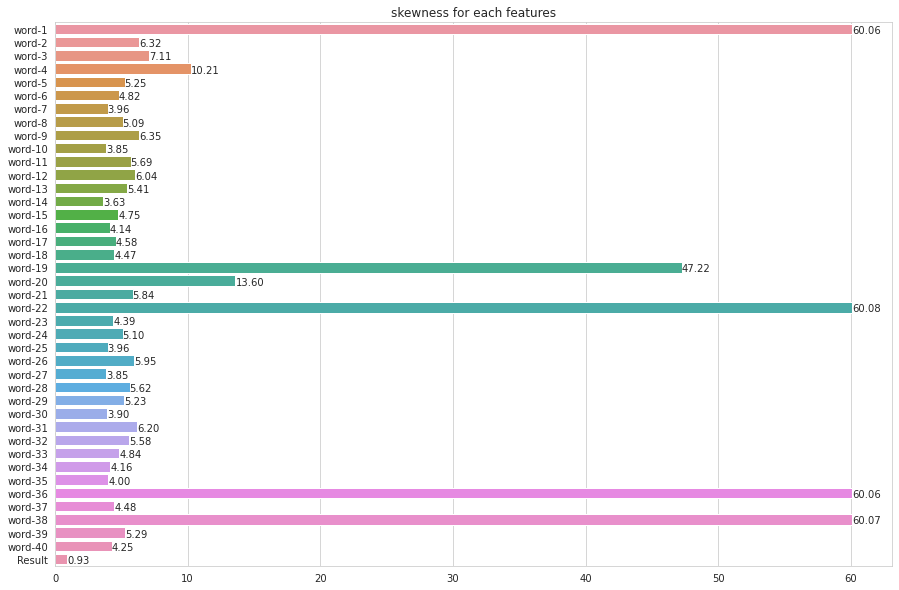

In [14]:
features = []
values = []
for var in train.columns[1:-1] :
    features.append(var)
    values.append(train[var].skew())
plt.figure(figsize = [15, 10])
sns.set_style('whitegrid')
sns.barplot(x = values,
            y = features)
for index, value in enumerate(values) :
    plt.text(value, index+.3, '%.2f'%value)
plt.title('skewness for each features')

since none of the columns have small skew (close to 0), the average value is used to fill NaN values in the dataset.

before replacing missing values with average, it's necessary to identify observations with extreme values. observations with extreme values may cause bad imputation.

Text(0.5, 1.0, 'Maximum words frequencey for each features (train set)')

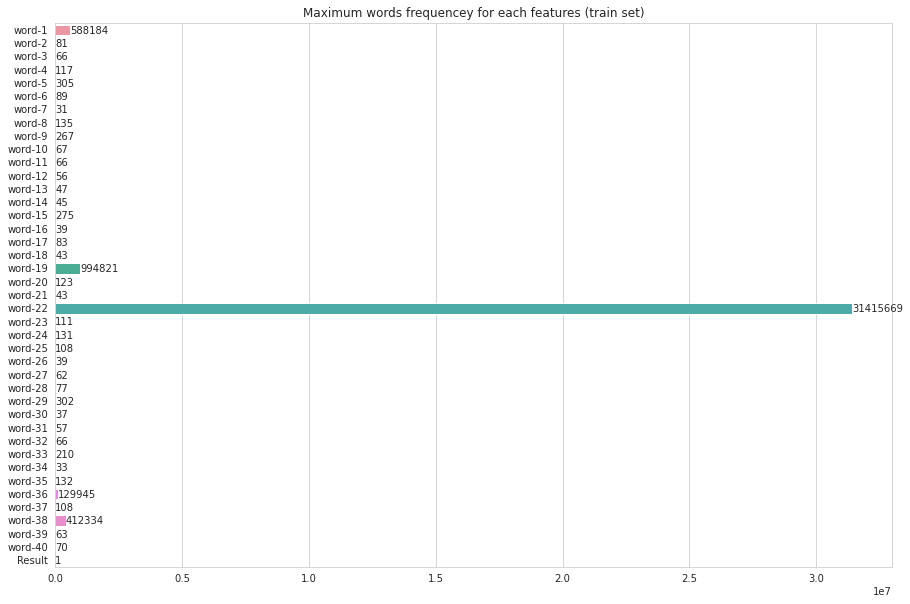

In [15]:
features = []
values = []
for var in train.columns[1:-1] :
    features.append(var)
    values.append(train[var].max())
plt.figure(figsize = [15, 10])
sns.barplot(x = values,
            y = features)
for index, value in enumerate(values) :
    plt.text(value, index+.3, str(int(value)))
plt.title('Maximum words frequencey for each features (train set)')

Text(0.5, 1.0, 'Maximum words frequencey for each features (test set)')

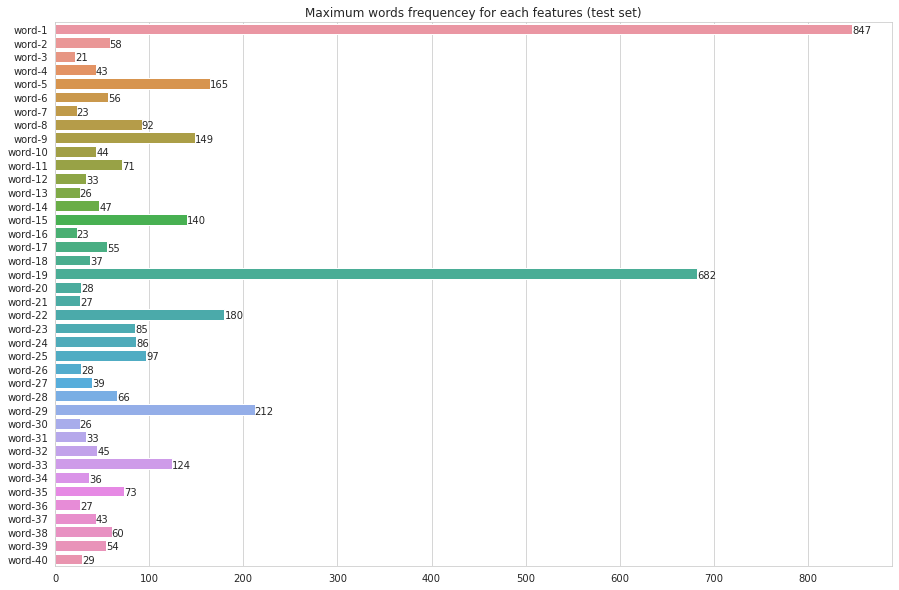

In [16]:
features = []
values = []
for var in test.columns[1:] :
    features.append(var)
    values.append(test[var].max())
plt.figure(figsize = [15, 10])
sns.barplot(x = values,
            y = features)
for index, value in enumerate(values) :
    plt.text(value, index+.3, str(int(value)))
plt.title('Maximum words frequencey for each features (test set)')

there are 5 words with extreme values. next, boxplot is needed in order to roughly identify the distribution of extreme values.

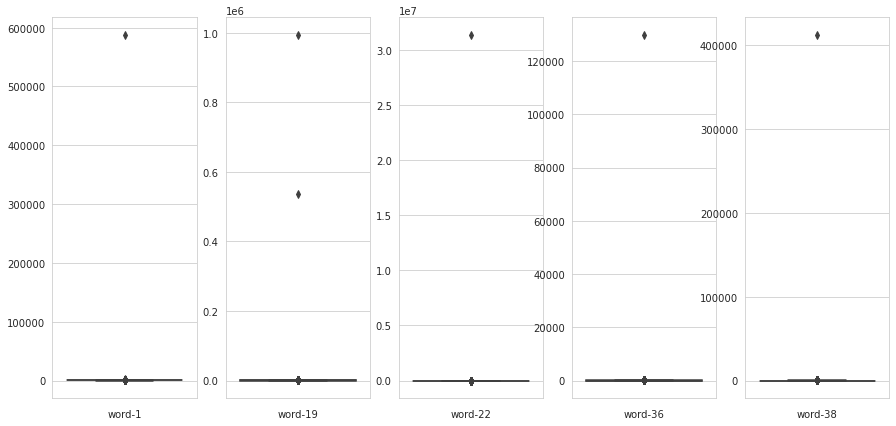

In [17]:
fig, ax = plt.subplots(1, 5, figsize = [15, 7])
i = 0
for col in ['word-1', 'word-19', 'word-22', 'word-36', 'word-38'] :
    sns.boxplot(y = train[col],
                ax = ax[i])
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('')
    i += 1

all of the words with extreme values except word-19 have only 1 extreme observation.

In [18]:
#train[~train['id'].isin(list(train[train['word-1'] == 588184]['id']))]['word-1'].max()
print('word-1 -> max word before = {before}; max word after = {after}'.format(after = round(train[~train['id'].isin(list(train[train['word-1'] == train['word-1'].max()]['id']))]['word-1'].max()),
                                                   before = round(train['word-1'].max())))

print('word-19 -> max word before = {before}; max word after = {after}'.format(after = round(train[~train['id'].isin(list(train[train['word-19'] == train['word-19'].max()]['id']))]['word-19'].max()),
                                                   before = round(train['word-19'].max())))

print('word-22 -> max word before = {before}; max word after = {after}'.format(after = round(train[~train['id'].isin(list(train[train['word-22'] == train['word-22'].max()]['id']))]['word-22'].max()),
                                                   before = round(train['word-22'].max())))

print('word-36 -> max word before = {before}; max word after = {after}'.format(after = round(train[~train['id'].isin(list(train[train['word-36'] == train['word-36'].max()]['id']))]['word-36'].max()),
                                                   before = round(train['word-36'].max())))

print('word-38 -> max word before = {before}; max word after = {after}'.format(after = round(train[~train['id'].isin(list(train[train['word-38'] == train['word-38'].max()]['id']))]['word-38'].max()),
                                                   before = round(train['word-38'].max())))

word-1 -> max word before = 588184; max word after = 1898
word-19 -> max word before = 994821; max word after = 536457
word-22 -> max word before = 31415669; max word after = 223
word-36 -> max word before = 129945; max word after = 67
word-38 -> max word before = 412334; max word after = 58


unlike word-1, 22, 36, 38, word-19 has 2 observations with extreme value. all of the extreme values will be treated

Text(0.5, 1.0, 'average words frequencey for each features (train set)')

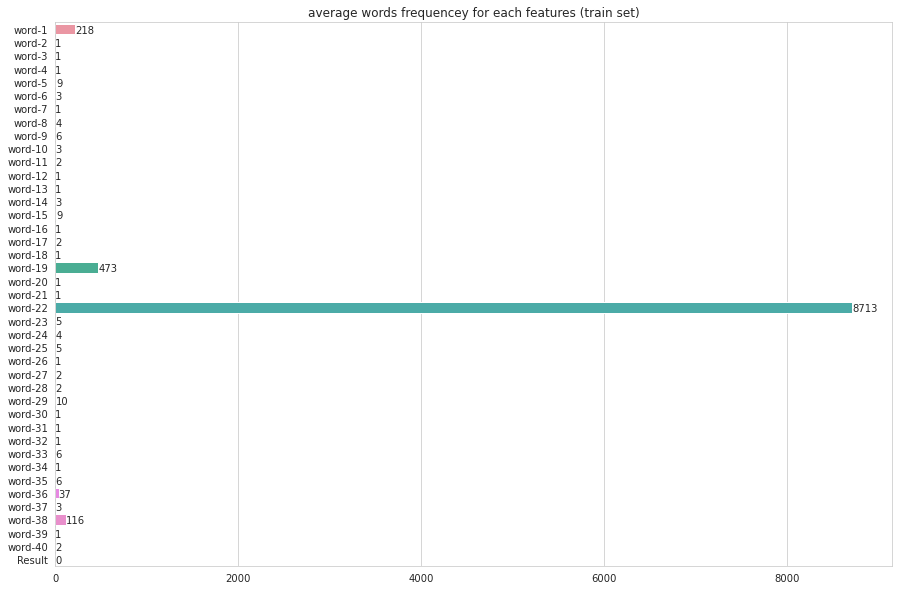

In [19]:
features = []
values = []
for var in train.columns[1:-1] :
    features.append(var)
    values.append(train[var].mean())
plt.figure(figsize = [15, 10])
sns.barplot(x = values,
            y = features)
for index, value in enumerate(values) :
    plt.text(value, index+.3, str(int(value)))
plt.title('average words frequencey for each features (train set)')

Text(0.5, 1.0, 'average words frequencey for each features (test set)')

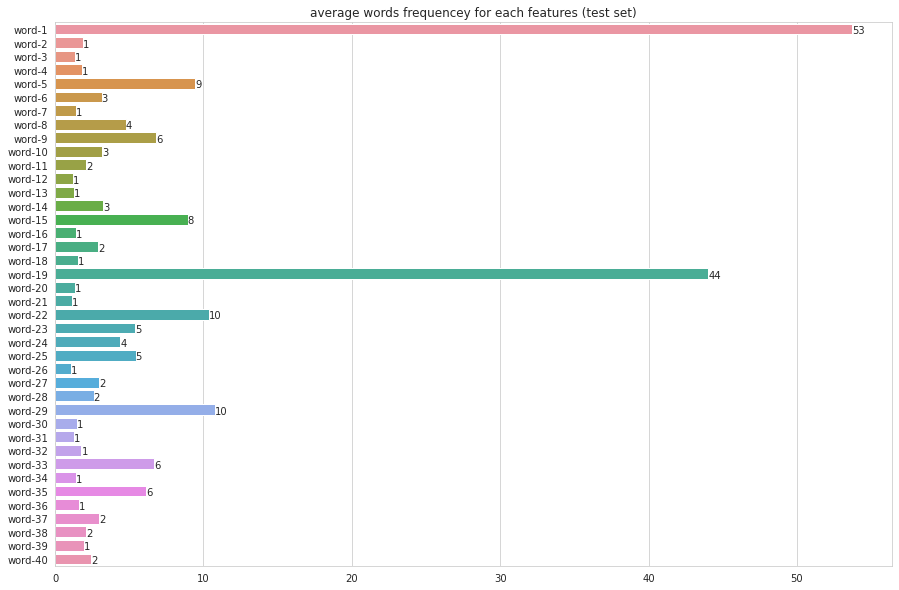

In [20]:
features = []
values = []
for var in test.columns[1:] :
    features.append(var)
    values.append(test[var].mean())
plt.figure(figsize = [15, 10])
sns.barplot(x = values,
            y = features)
for index, value in enumerate(values) :
    plt.text(value, index+.3, str(int(value)))
plt.title('average words frequencey for each features (test set)')

In [21]:
#train[~train['id'].isin(list(train[train['word-1'] == 588184]['id']))]['word-1'].mean()
print('word-1 -> before = {before}; after = {after}'.format(after = round(train[~train['id'].isin(list(train[train['word-1'] == train['word-1'].max()]['id']))]['word-1'].mean()),
                                                   before = round(train['word-1'].mean())))

print('word-19 -> before = {before}; after = {after}'.format(after = round(train[~train['id'].isin(list(train[train['word-19'] == train['word-19'].max()]['id']))]['word-19'].mean()),
                                                   before = round(train['word-19'].mean())))

print('word-22 -> before = {before}; after = {after}'.format(after = round(train[~train['id'].isin(list(train[train['word-22'] == train['word-22'].max()]['id']))]['word-22'].mean()),
                                                   before = round(train['word-22'].mean())))

print('word-36 -> before = {before}; after = {after}'.format(after = round(train[~train['id'].isin(list(train[train['word-36'] == train['word-36'].max()]['id']))]['word-36'].mean()),
                                                   before = round(train['word-36'].mean())))

print('word-38 -> before = {before}; after = {after}'.format(after = round(train[~train['id'].isin(list(train[train['word-38'] == train['word-38'].max()]['id']))]['word-38'].mean()),
                                                   before = round(train['word-38'].mean())))

word-1 -> before = 218; after = 55
word-19 -> before = 473; after = 196
word-22 -> before = 8713; after = 11
word-36 -> before = 38; after = 2
word-38 -> before = 117; after = 2


In [22]:
# BEFORE
print(train['word-1'].max())
print(train['word-19'].max())
print(train['word-22'].max())
print(train['word-36'].max())
print(train['word-38'].max())

for feature in ['word-1', 'word-22', 'word-36', 'word-38'] :
    train.loc[train[feature] == train[feature].max(), feature] = round(train.loc[train[feature] != train[feature].max(), feature].mean())

588184.0
994821.0
31415669.0
129945.0
412334.0


In [23]:
# AFTER
print(train['word-1'].max())
print(train['word-19'].max())
print(train['word-22'].max())
print(train['word-36'].max())
print(train['word-38'].max())

1898.0
994821.0
223.0
67.0
58.0


In [24]:
print('before : word-19 max = {Max}; mean = {mean}'.format(Max = train['word-19'].max(), mean = train['word-19'].mean()))
train.loc[train['id'].isin(train[train['word-19'] > 50000]['id']), 'word-19'] = round(train.loc[train['id'].isin(train[train['word-19'] < 50000]['id']), 'word-19'].mean())
print('after : word-19 max = {Max}; mean = {mean}'.format(Max = train['word-19'].max(),mean = train['word-19'].mean()))

before : word-19 max = 994821.0; mean = 473.29224762967095
after : word-19 max = 972.0; mean = 46.30228667038483


Text(0.5, 1.0, 'Maximum words frequencey for each features (train set)')

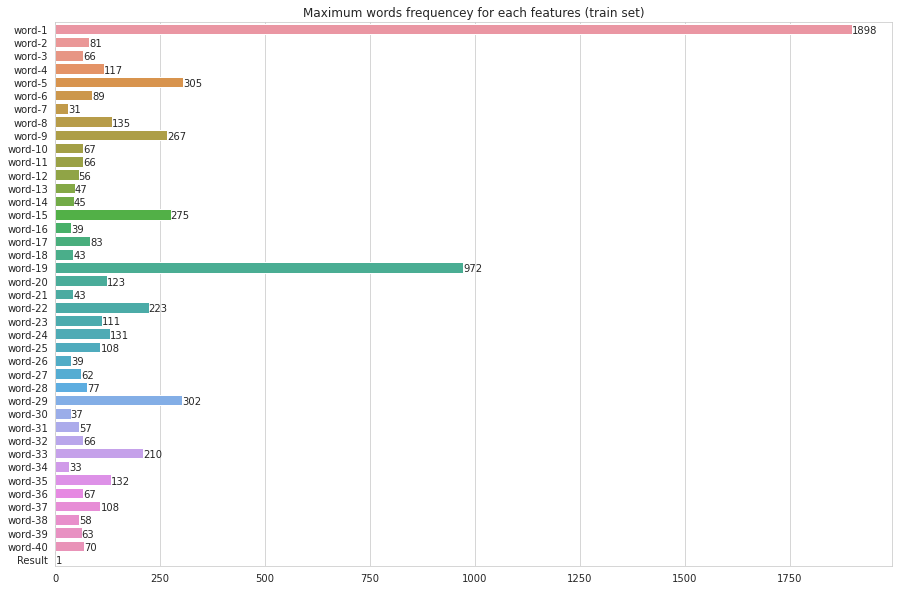

In [25]:
features = []
values = []
for var in train.columns[1:-1] :
    features.append(var)
    values.append(train[var].max())
plt.figure(figsize = [15, 10])
sns.barplot(x = values,
            y = features)
for index, value in enumerate(values) :
    plt.text(value, index+.3, str(int(value)))
plt.title('Maximum words frequencey for each features (train set)')

all of the extreme values are sucessfully treated.

1. identifying missing values

In [26]:
number_of_missing = [train[train['id'] == ID].isnull().sum().sum() for ID in (list(train[train.isna().any(axis = 1)]['id']))]
dict_missing = {'id' : train[train.isna().any(axis = 1)]['id'], 
                '#missing' : number_of_missing}
pd.DataFrame(dict_missing).sort_values(by = '#missing', ascending = False).head()

,id,#missing
1799,1800.0,29
1791,1792.0,14
2813,2814.0,8
1812,1813.0,4
899,900.0,3


In [27]:
number_of_missing_test = [test[test['id'] == ID].isnull().sum().sum() for ID in (list(test[test.isna().any(axis = 1)]['id']))]
dict_missing_test = {'id' : test[test.isna().any(axis = 1)]['id'], '#missing' : number_of_missing_test}
pd.DataFrame(dict_missing_test).sort_values(by = '#missing', ascending = False).head()

,id,#missing
1471,5092.0,5
1295,4916.0,5
888,4509.0,5
839,4460.0,5
1116,4737.0,5


in the training set, there are 2 observations which have more than 10 missing values. those observations are going to be removed.

in the testing set, maximum amount of missing values is only 5 so all of the missing values in the testing set are going to be replaced with statistics.

In [28]:
print(train.shape) #before dropping 2 observations with so many missing values
train = train[~train['id'].isin([1800, 1792])]
print(train.shape) #after dropping 2 observations

(3620, 43)
(3618, 43)


2. filling nan values

Nan values will be replaced by rounded average of each features. For testing set, missing values will be replaced using the rounded average obtained from training set.

In [29]:
train = round(train.fillna(train.mean()))
test = round(test.fillna(train.mean()))
train['total_words'] = train.iloc[:, 1:41].sum(axis = 1)
test['total_words'] = test.iloc[:, 1:].sum(axis = 1)

checking if the treatment was complete

In [30]:
print(train.loc[train['id'] == 3582, 'word-1'])
print(train.loc[train['id'] == 2870, 'word-18'])
print(train.loc[train['id'] == 1938, 'word-40'])

3581    55.0
Name: word-1, dtype: float64
2869    1.0
Name: word-18, dtype: float64
1937    2.0
Name: word-40, dtype: float64


detecting variables that contain negative observation

In [31]:
for col in train.columns[1:41] :
    print(col + ' ' + str(train[train[col] < 0 ].index))

word-1 Int64Index([], dtype='int64')
word-2 Int64Index([], dtype='int64')
word-3 Int64Index([], dtype='int64')
word-4 Int64Index([32], dtype='int64')
word-5 Int64Index([], dtype='int64')
word-6 Int64Index([], dtype='int64')
word-7 Int64Index([], dtype='int64')
word-8 Int64Index([], dtype='int64')
word-9 Int64Index([], dtype='int64')
word-10 Int64Index([], dtype='int64')
word-11 Int64Index([], dtype='int64')
word-12 Int64Index([], dtype='int64')
word-13 Int64Index([], dtype='int64')
word-14 Int64Index([], dtype='int64')
word-15 Int64Index([], dtype='int64')
word-16 Int64Index([], dtype='int64')
word-17 Int64Index([], dtype='int64')
word-18 Int64Index([], dtype='int64')
word-19 Int64Index([], dtype='int64')
word-20 Int64Index([], dtype='int64')
word-21 Int64Index([], dtype='int64')
word-22 Int64Index([], dtype='int64')
word-23 Int64Index([], dtype='int64')
word-24 Int64Index([], dtype='int64')
word-25 Int64Index([24], dtype='int64')
word-26 Int64Index([], dtype='int64')
word-27 Int64Inde

In [32]:
for col in test.columns[1:39] :
    print(col + ' ' + str(test[test[col] < 0 ].index))

word-1 Int64Index([], dtype='int64')
word-2 Int64Index([], dtype='int64')
word-3 Int64Index([], dtype='int64')
word-4 Int64Index([], dtype='int64')
word-5 Int64Index([], dtype='int64')
word-6 Int64Index([], dtype='int64')
word-7 Int64Index([], dtype='int64')
word-8 Int64Index([], dtype='int64')
word-9 Int64Index([], dtype='int64')
word-10 Int64Index([], dtype='int64')
word-11 Int64Index([], dtype='int64')
word-12 Int64Index([], dtype='int64')
word-13 Int64Index([], dtype='int64')
word-14 Int64Index([], dtype='int64')
word-15 Int64Index([], dtype='int64')
word-16 Int64Index([], dtype='int64')
word-17 Int64Index([], dtype='int64')
word-18 Int64Index([], dtype='int64')
word-19 Int64Index([], dtype='int64')
word-20 Int64Index([], dtype='int64')
word-21 Int64Index([], dtype='int64')
word-22 Int64Index([], dtype='int64')
word-23 Int64Index([], dtype='int64')
word-24 Int64Index([], dtype='int64')
word-25 Int64Index([], dtype='int64')
word-26 Int64Index([], dtype='int64')
word-27 Int64Index([]

there are 2 observations that are measured as negative values in the training set while there's no such value in the testing set. those observations are treated by converting them into positive values

In [33]:
for col in ['word-4', 'word-25'] :
    train[col] = [row*-1 if row < 0 else row for row in train[col]]

In [34]:
for col in ['word-4', 'word-25'] :
    print(col + ' ' + str(train[train[col] < 0 ].index))

word-4 Int64Index([], dtype='int64')
word-25 Int64Index([], dtype='int64')


In [35]:
train_cleaned = train.copy()
test_cleaned = test.copy()

# EDA

Text(0.5, 1.0, 'Percentage of e-mails containing specific words')

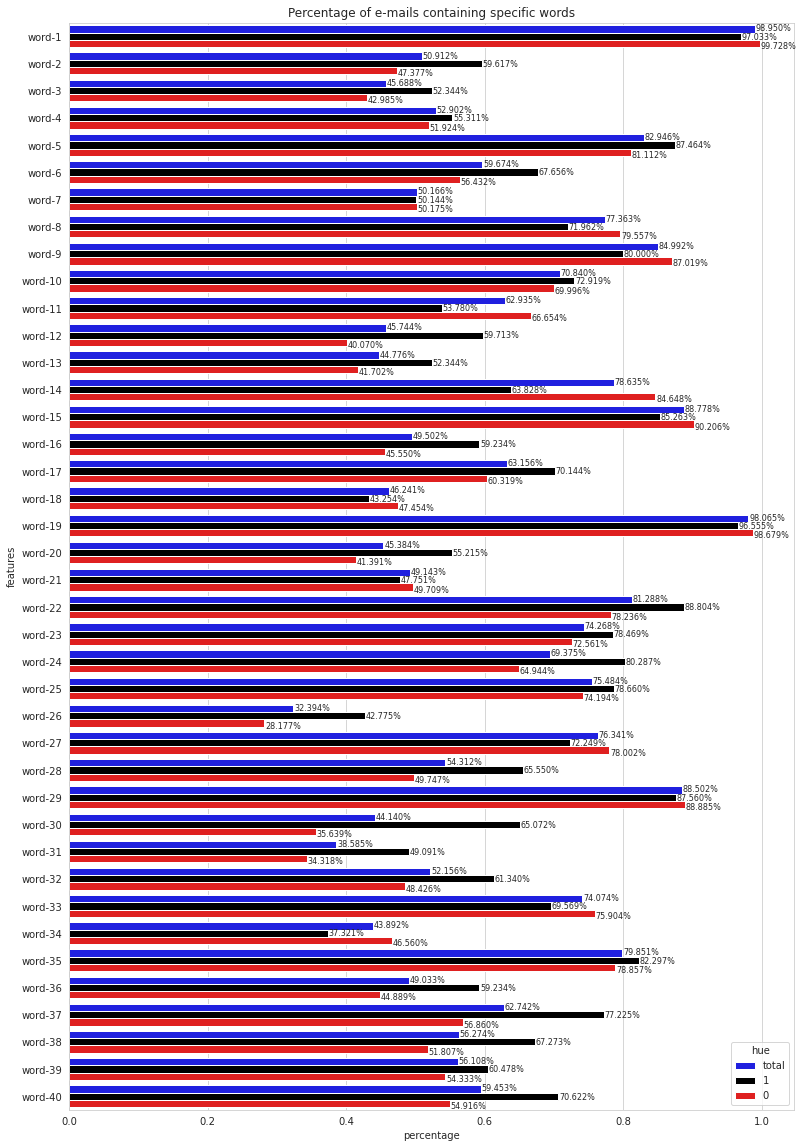

In [36]:
#train[train['Result'] == 1].shape[0]
words = []
word_total_percentage = []
for col in train.columns[1:41] :
    words.append(col)
    word_total_percentage.append(train[(train[col] != 0)].shape[0]/train.shape[0])

word_percentage_1 = []
words = []
for col in train.columns[1:41] :
    words.append(col)
    word_percentage_1.append(train[(train['Result'] == 1) & (train[col] != 0)].shape[0]/train[train['Result'] == 1].shape[0])

    
word_percentage_0 = []
words = []
for col in train.columns[1:41] :
    words.append(col)
    word_percentage_0.append(train[(train['Result'] == 0) & (train[col] != 0)].shape[0]/train[train['Result'] == 0].shape[0])

    
vis_df = pd.DataFrame({'features' : list(train.columns[1:41]) + list(train.columns[1:41]) + list(train.columns[1:41]),
                       'percentage' : word_total_percentage + word_percentage_1 + word_percentage_0,
                       'hue' : list(np.repeat('total', 40)) + list('1'*40) + list('0'*40)})
plt.figure(figsize = [13, 20])
sns.barplot(data = vis_df,
            x = 'percentage',
            y = 'features',
            hue = 'hue', 
            hue_order= ['total', '1', '0'],
            palette = ['blue', 'black', 'red'])

for index, value in enumerate(vis_df['percentage'].iloc[:40]) :
    plt.text(value+.001, index-.2, str('%.3f'%(value*100) +'%'), size = 8)

for index, value in enumerate(vis_df['percentage'].iloc[40:80]) :
    plt.text(value+.001, index+.1, str('%.3f'%(value*100) +'%'), size = 8)
    
for index, value in enumerate(vis_df['percentage'].iloc[80:]) :
    plt.text(value+.001, index+.45, str('%.3f'%(value*100) +'%'), size = 8)
plt.title('Percentage of e-mails containing specific words')

interpretation of those categories :
- total : percentage of all e-mails containing a specific word
- 1 : pecentage of only spam e-mails containing a specific word
- 0 : percentage of only non spam e-mails containing a specific word

There are some words that probably would be good predictors because they have more percentages in spam e-mails than in non spam e-mails. This is crucial especially for an imbalanced class. Words like word-12, word-30, and word-37 fit to that category.

Text(0.5, 1.0, 'Average Proportion of words for each e-mails')

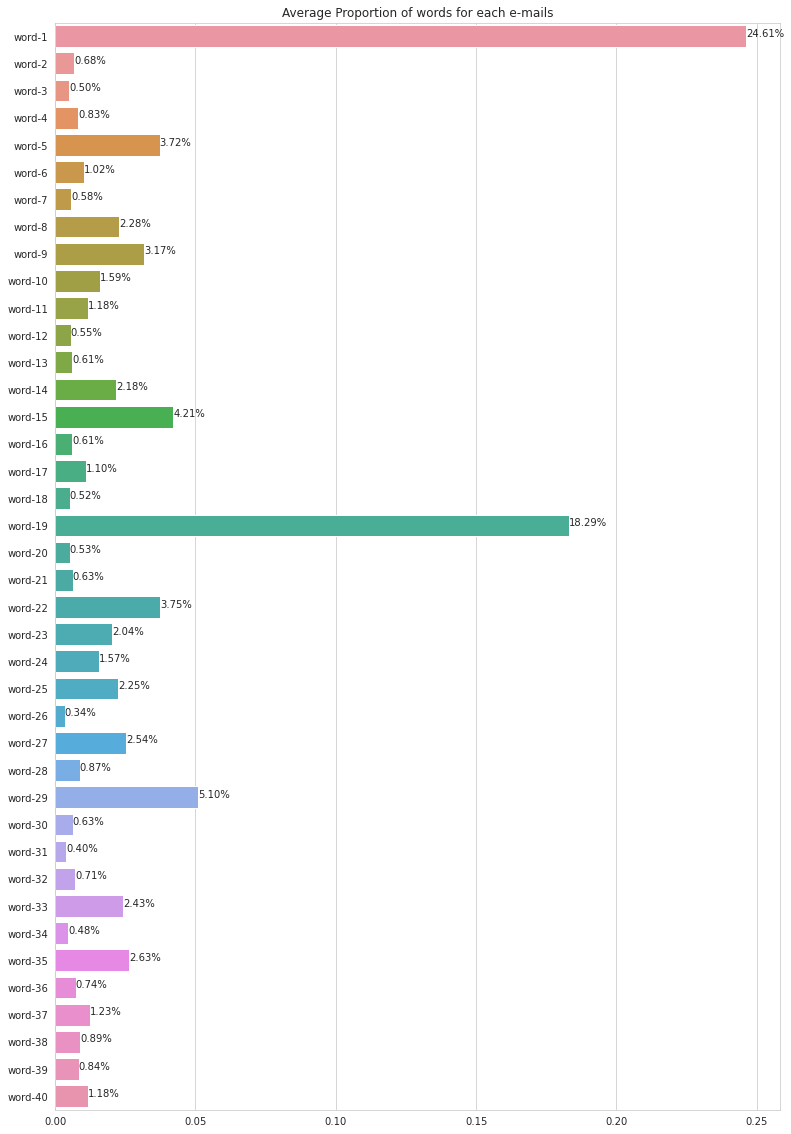

In [37]:
#train[train['Result'] == 1].shape[0]
train_vis = train[train['total_words'] != 0]
words = []
word_percentage_per_total = []
word_percentage_per_total_std = []
for col in train_vis.columns[1:41] :
    words.append(col)
    word_percentage_per_total.append((train_vis[col]/train_vis['total_words']).mean())
    word_percentage_per_total_std.append((train_vis[col]/train_vis['total_words']).std())
    
vis_df = pd.DataFrame({'features' : list(train.columns[1:41]),
                       'percentage' : word_percentage_per_total})
plt.figure(figsize = [13, 20])
sns.barplot(data = vis_df,
            y = words,
            x = word_percentage_per_total)
for index, value in enumerate(word_percentage_per_total) :
    plt.text(value, index, str('%.2f'%(value*100) +'%'))
plt.title('Average Proportion of words for each e-mails')

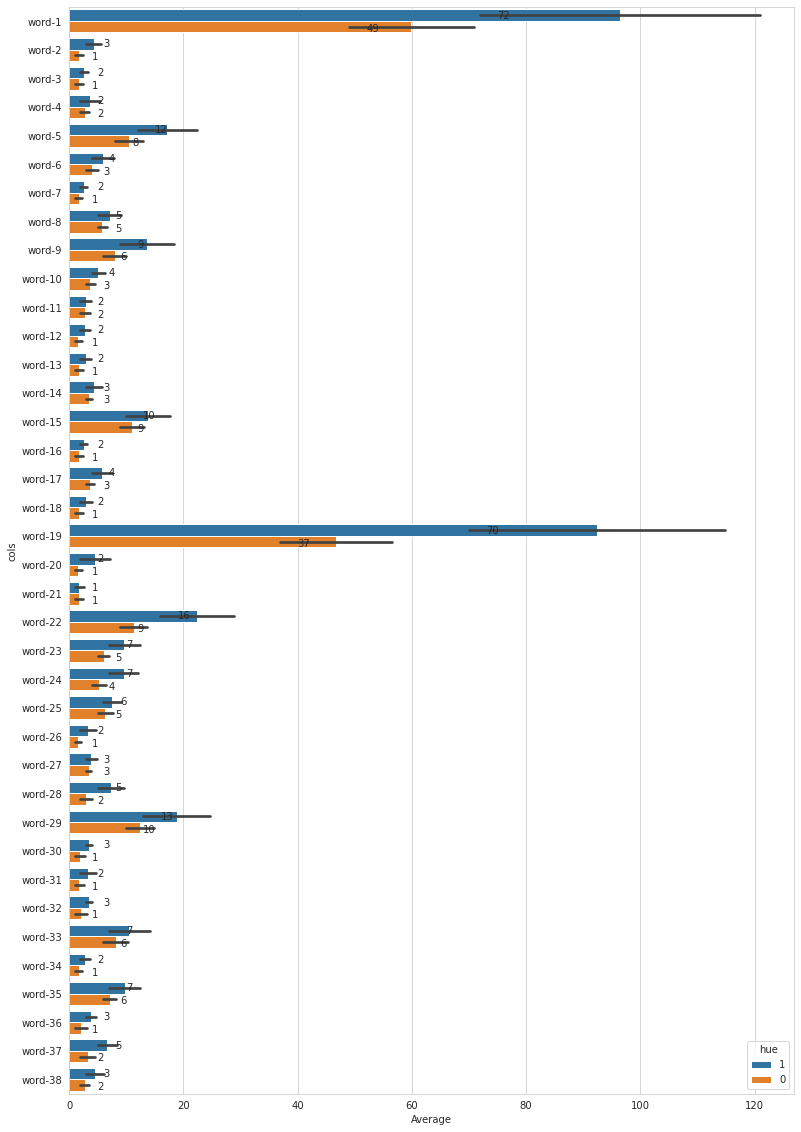

In [38]:
#train[train['Result'] == 1].shape[0]
word_percentage_average_1 = []
word_feature_std_1 = []
words = []
for col in train.columns[1:39] :
    words.append(col)
    word_percentage_average_1.append(round(train[train['Result'] == 1][col].mean()))
    word_feature_std_1.append(train[train['Result'] == 1][col].std())

    
word_percentage_average_0 = []
word_feature_std_0 = []
words = []
for col in train.columns[1:39] :
    words.append(col)
    word_percentage_average_0.append(round(train[train['Result'] == 0][col].mean()))
    word_feature_std_0.append(train[train['Result'] == 0][col].std())

    
vis_df_average = pd.DataFrame({'cols' : list(train.columns[1:39]) + list(train.columns[1:39]) + list(train.columns[1:39]) + list(train.columns[1:39]),
                               'percentage' : word_percentage_average_1 + word_percentage_average_0 + word_feature_std_1 + word_feature_std_0,
                               'hue' : list('1'*38) + list('0'*38) + list('1'*38) + list('0'*38)})
plt.figure(figsize = [13, 20])
sns.barplot(data = vis_df_average,
            x = 'percentage',
            y = 'cols',
            hue = 'hue',
            hue_order = ['1', '0'])
plt.xlabel('Average')
for index, value in enumerate(vis_df_average['percentage'].iloc[:38]) :
    plt.text(value + 3, index-.1, str('%.0f'%value))
    
for index, value in enumerate(vis_df_average['percentage'].iloc[38:76]) :
    plt.text(value + 3, index+.35, str('%.0f'%value))

from the 3 plots above it's pretty obvious that word-1 and word-19 are probably unimportant words like stopwords or words that do not have a meaningful representation at each e-mails. word-1 and word-19 are going to be removed.

In [39]:
train = train.drop(columns = ['word-1', 'word-19'])
test = test.drop(columns = ['word-1', 'word-19'])
train_copy = train.copy()
test_copy = test.copy()
train['total_words'] = train.iloc[:, 1:39].sum(axis = 1)
test['total_words'] = test.iloc[:, 1:-1].sum(axis = 1)
train_copy['total_words'] = train_copy.iloc[:, 1:39].sum(axis = 1)
test_copy['total_words'] = test_copy.iloc[:, 1:-1].sum(axis = 1)

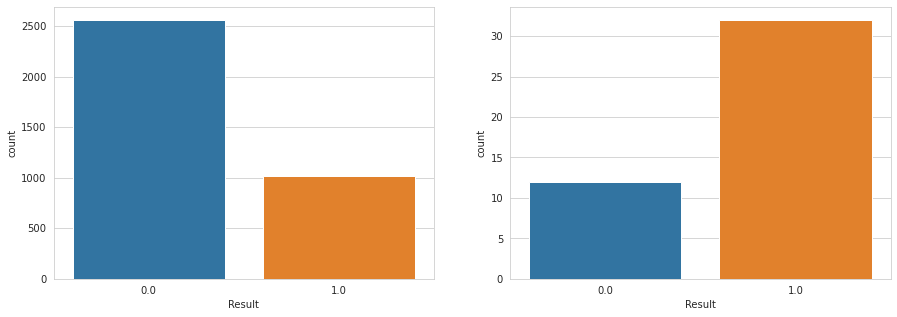

In [40]:
fig, ax = plt.subplots(1, 2, figsize = [15, 5])
sns.countplot(train[train['total_words'] < 1000]['Result'], 
              ax = ax[0])
sns.countplot(train[(train['total_words'] >= 1000)]['Result'], 
              ax = ax[1])
#sns.countplot(train[train['total_words'] > 3000]['Result'], ax = ax[2])

the more total words in an e-mail, the higher probability of an e-mail to be categorized as spam e-mail escpecially for e-mails that have more than 1000 words as shown at the plot above.

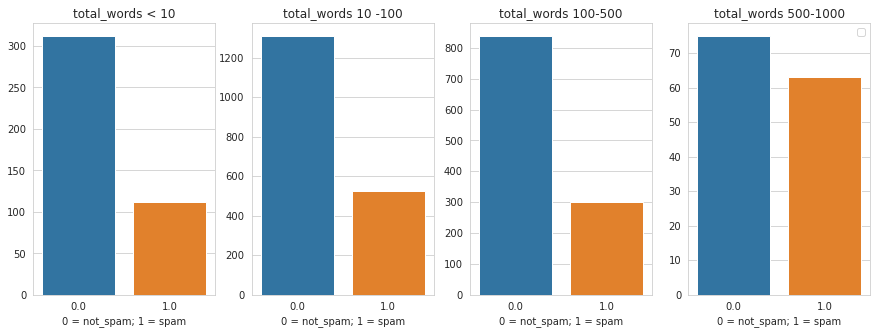

In [41]:
fig, ax = plt.subplots(1, 4, figsize = [15, 5])
sns.countplot(train[train['total_words'] < 10]['Result'], ax = ax[0])
sns.countplot(train[(train['total_words'] > 10) & (train['total_words'] < 100)]['Result'], ax = ax[1])
sns.countplot(train[(train['total_words'] > 100) & (train['total_words'] < 500)]['Result'], ax = ax[2])
sns.countplot(train[(train['total_words'] >= 500) & (train['total_words'] < 1000)]['Result'], ax = ax[3])
ax[0].set_title('total_words < 10')
ax[0].set_ylabel('')
ax[0].set_xlabel('0 = not_spam; 1 = spam')

ax[1].set_title('total_words 10 -100')
ax[1].set_xlabel('0 = not_spam; 1 = spam')
ax[1].set_ylabel('')

ax[2].set_title('total_words 100-500')
ax[2].set_ylabel('')
ax[2].set_xlabel('0 = not_spam; 1 = spam')

ax[3].set_title('total_words 500-1000')
ax[3].set_xlabel('0 = not_spam; 1 = spam')
ax[3].set_ylabel('')
plt.legend()

FE

Features that are manually synthesized

In [42]:
train['average_words'] = list(map(math.ceil, train.iloc[:, 1:39].mean(axis = 1)))
train['total_words'] = train.iloc[:, 1:39].sum(axis = 1)
train['variance_words'] = train.iloc[:, 1:39].var(axis = 1)
train['skew_words'] = train.iloc[:, 1:39].skew(axis = 1)
train['kurtosis_words'] = train.iloc[:, 1:39].kurtosis(axis = 1)
train['max_words'] = train.iloc[:, 1:39].max(axis = 1)
train['min_words'] = train.iloc[:, 1:39].min(axis = 1)
train['median_words'] = train.iloc[:, 1:39].median(axis = 1)
train['std_words'] = list(map(math.ceil, train.iloc[:, 1:39].std(axis = 1)))

test['average_words'] = list(map(math.ceil, test.iloc[:, 1:39].mean(axis = 1)))
test['total_words'] = test.iloc[:, 1:39].sum(axis = 1)
test['variance_words'] = test.iloc[:, 1:39].var(axis = 1)
test['skew_words'] = test.iloc[:, 1:39].skew(axis = 1)
test['kurtosis_words'] = test.iloc[:, 1:39].kurtosis(axis = 1)
test['max_words'] = test.iloc[:, 1:39].max(axis = 1)
test['min_words'] = test.iloc[:, 1:39].min(axis = 1)
test['median_words'] = test.iloc[:, 1:39].median(axis = 1)
test['std_words'] = list(map(math.ceil, test.iloc[:, 1:39].std(axis = 1)))


new_features = ['average_words', 
                'total_words', 
                'variance_words', 
                'skew_words', 
                'kurtosis_words',
                'max_words',
                'min_words',
                'median_words',
                'std_words']

SPLITTING TRAIN AND VALIDATION SET

In [111]:
from sklearn.model_selection import train_test_split
x_train_train1, x_train_validation1, y_train_train1, y_train_validation1 = train_test_split(train[train['total_words'] != 0],
                                                                                            train[train['total_words'] != 0]['Result'],
                                                                                            train_size = 0.7,
                                                                                            stratify = train[train['total_words'] != 0]['Result'],
                                                                                            random_state = 1)

In [44]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.feature_extraction.text import TfidfTransformer

There are some approaches/techniques in order to transform Bag of Words features. These techniques are also known as weighting schemes or also known as Term Frequency - Inverse Document Frequency (TF-IDF). 

https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In this section, TF-IDFs datasets will be generated to compare their performance to baseline model.

GENERATING TF-IDF DATASET

TF

In [45]:
train_tf_1 = pd.concat([train.iloc[:, 1:39].reset_index(drop = True),
                      train['total_words'].reset_index(drop = True),
                      train['Result'].reset_index(drop = True)],
                     axis = 1)
for col in tqdm(train_tf_1.columns[:-2]) :
    train_tf_1[col] = (train_tf_1[col])/(train_tf_1['total_words'])
train_tf_1.head()

test_tf_1 = pd.concat([test.iloc[:, 1:39].reset_index(drop = True),
                      test['total_words'].reset_index(drop = True)],
                    axis = 1)
for col in tqdm(test_tf_1.columns[:-2]) :
    test_tf_1[col] = (test_tf_1[col])/(test_tf_1['total_words'])
test_tf_1.head()

,word-2,word-3,word-4,word-5,word-6,word-7,word-8,word-9,word-10,word-11,...,word-32,word-33,word-34,word-35,word-36,word-37,word-38,word-39,word-40,total_words
0,0.0,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,...,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.0,11.0
1,0.0,0.009174,0.009174,0.091743,0.027523,0.027523,0.055046,0.055046,0.027523,0.027523,...,0.018349,0.045872,0.027523,0.055046,0.000000,0.009174,0.000000,0.009174,4.0,109.0
2,0.0,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.105263,0.000000,0.315789,0.000000,0.000000,0.000000,0.105263,0.0,19.0
3,0.0,0.000000,0.000000,0.075269,0.000000,0.010753,0.043011,0.043011,0.053763,0.000000,...,0.010753,0.043011,0.000000,0.053763,0.021505,0.032258,0.032258,0.032258,5.0,93.0
4,0.0,0.006579,0.013158,0.105263,0.046053,0.013158,0.078947,0.013158,0.039474,0.013158,...,0.006579,0.026316,0.013158,0.085526,0.026316,0.006579,0.000000,0.000000,4.0,152.0


In [46]:
train_tf_2 = pd.concat([train.iloc[:, 1:39].reset_index(drop = True),
                      train['total_words'].reset_index(drop = True),
                      train['Result'].reset_index(drop = True)],
                     axis = 1)
for col in tqdm(train_tf_2.columns[:-2]) :
    train_tf_2[col] = [math.log((row + 1), 10) for row in train[col]]
train_tf_2.head()

test_tf_2 = pd.concat([test.iloc[:, 1:39].reset_index(drop = True),
                      test['total_words'].reset_index(drop = True)],
                    axis = 1)
for col in tqdm(test_tf_2.columns[:-2]) :
    test_tf_2[col] = [math.log(row + 1, 10) for row in test_tf_2[col]]
test_tf_2.head()

,word-2,word-3,word-4,word-5,word-6,word-7,word-8,word-9,word-10,word-11,...,word-32,word-33,word-34,word-35,word-36,word-37,word-38,word-39,word-40,total_words
0,0.0,0.00000,0.000000,0.301030,0.00000,0.000000,0.000000,0.000000,0.301030,0.000000,...,0.000000,0.301030,0.000000,0.000000,0.000000,0.00000,0.30103,0.000000,0.0,11.0
1,0.0,0.30103,0.301030,1.041393,0.60206,0.602060,0.845098,0.845098,0.602060,0.602060,...,0.477121,0.778151,0.602060,0.845098,0.000000,0.30103,0.00000,0.301030,4.0,109.0
2,0.0,0.00000,0.000000,0.301030,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.477121,0.000000,0.845098,0.000000,0.00000,0.00000,0.477121,0.0,19.0
3,0.0,0.00000,0.000000,0.903090,0.00000,0.301030,0.698970,0.698970,0.778151,0.000000,...,0.301030,0.698970,0.000000,0.778151,0.477121,0.60206,0.60206,0.602060,5.0,93.0
4,0.0,0.30103,0.477121,1.230449,0.90309,0.477121,1.113943,0.477121,0.845098,0.477121,...,0.301030,0.698970,0.477121,1.146128,0.698970,0.30103,0.00000,0.000000,4.0,152.0


In [47]:
train_tf_3 = pd.concat([train[train['total_words'] != 0].iloc[:, 1:39].reset_index(drop = True),
                        train[train['total_words'] != 0]['total_words'].reset_index(drop = True),
                        train[train['total_words'] != 0]['Result'].reset_index(drop = True)],
                       axis = 1)
train_tf_3['max_term'] = train_tf_3.iloc[:, 1:38].max(axis = 1)
for col in tqdm(train_tf_3.columns[:-2]) :
    train_tf_3[col] = 0.5 + (0.5*train_tf_3[col]/train_tf_3['max_term'])
train_tf_3.head()

test_tf_3 = pd.concat([test.iloc[:, 1:39].reset_index(drop = True),
                       test['total_words'].reset_index(drop = True)],
                      axis = 1)
test_tf_3['max_term'] = test_tf_3.iloc[:, 1:38].max(axis = 1)
for col in tqdm(test_tf_3.columns[:-2]) :
    test_tf_3[col] = 0.5 + (0.5*test_tf_3[col]/test_tf_3['max_term'])
test_tf_3.head()

,word-2,word-3,word-4,word-5,word-6,word-7,word-8,word-9,word-10,word-11,...,word-33,word-34,word-35,word-36,word-37,word-38,word-39,word-40,total_words,max_term
0,0.5,0.50000,0.5000,0.750000,0.50000,0.500000,0.500000,0.500000,0.750000,0.5000,...,0.750000,0.5000,0.500000,0.500000,0.50000,0.75,0.500000,0.500000,11.0,2.0
1,0.5,0.55000,0.5500,1.000000,0.65000,0.650000,0.800000,0.800000,0.650000,0.6500,...,0.750000,0.6500,0.800000,0.500000,0.55000,0.50,0.550000,0.700000,109.0,10.0
2,0.5,0.50000,0.5000,0.583333,0.50000,0.500000,0.500000,0.500000,0.500000,0.5000,...,0.666667,0.5000,1.000000,0.500000,0.50000,0.50,0.666667,0.500000,19.0,6.0
3,0.5,0.50000,0.5000,0.733333,0.50000,0.533333,0.633333,0.633333,0.666667,0.5000,...,0.633333,0.5000,0.666667,0.566667,0.60000,0.60,0.600000,0.666667,93.0,15.0
4,0.5,0.53125,0.5625,1.000000,0.71875,0.562500,0.875000,0.562500,0.687500,0.5625,...,0.625000,0.5625,0.906250,0.625000,0.53125,0.50,0.500000,0.625000,152.0,16.0


TF-IDF

In [49]:
train_tf_1_idf = train_tf_1.drop(columns = ['total_words', 'Result']).copy()
for col in train_tf_1_idf.columns :
    train_tf_1_idf[col] = train_tf_1_idf[col]*(math.log(train[train[col] != 0].shape[0]/train.shape[0]))
train_tf_1_idf['Result'] = train['Result']
train_tf_1_idf.head()

,word-2,word-3,word-4,word-5,word-6,word-7,word-8,word-9,word-10,word-11,...,word-32,word-33,word-34,word-35,word-36,word-37,word-38,word-39,word-40,Result
0,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.051332,-0.000000,-0.068949,-0.092613,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0
1,-0.002538,-0.011779,-0.007181,-0.007029,-0.009704,-0.005187,-0.008684,-0.011615,-0.007776,-0.001741,...,-0.007341,-0.014667,-0.027861,-0.012689,-0.008038,-0.005257,-0.028098,-0.006518,-0.001955,0.0
2,-0.009123,-0.010586,-0.043022,-0.020214,-0.020930,-0.018644,-0.006937,-0.004395,-0.004659,-0.006258,...,-0.008796,-0.020277,-0.011128,-0.003041,-0.009631,-0.000000,-0.000000,-0.000000,-0.000000,0.0
3,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.012509,-0.000000,-0.000000,...,-0.000000,-0.161595,-0.000000,-0.000000,-0.000000,-0.000000,-0.088451,-0.000000,-0.000000,0.0
4,-0.005770,-0.008927,-0.007256,-0.002663,-0.019121,-0.000983,-0.007678,-0.008108,-0.004911,-0.003298,...,-0.009273,-0.002992,-0.005865,-0.015706,-0.026396,-0.015936,-0.018837,-0.003293,-0.017777,1.0


BASELINE MODEL CROSSVALIDATION

In [135]:
algorithms = [AdaBoostClassifier(random_state = 2),
              BaggingClassifier(random_state = 2),
              ExtraTreesClassifier(random_state = 2),
              GradientBoostingClassifier(random_state = 2),
              RandomForestClassifier(random_state = 2),
              SVC(),
              LogisticRegression(),
              GaussianNB(),
              XGBClassifier(random_state = 2),
              LGBMClassifier(random_state = 2),
              CatBoostClassifier(random_state = 2, verbose = False)]

algo = []
cv_baseline_accuracy_1 = []
cv_baseline_f1_1 = []
for algorithm in tqdm(algorithms) :
    algo.append(type(algorithm).__name__)
    cv_baseline_accuracy_1.append(cross_val_score(algorithm,
                                                  train[train['total_words'] != 0].drop(columns = ['id', 'Result'] + new_features),
                                                  train[train['total_words'] != 0]['Result'],
                                                  cv = StratifiedKFold(10),
                                                  scoring = 'accuracy').mean())
    
    #cv_baseline_accuracy_1.append(cross_val_score(algorithm,
                                                  #train_cleaned[train_cleaned['total_words'] != 0].get(key = ['word-30', 'word-1', 'word-19']),
                                                  #train_cleaned[train_cleaned['total_words'] != 0]['Result'],
                                                  #cv = StratifiedKFold(10),
                                                  #scoring = 'accuracy').mean())
    
    cv_baseline_f1_1.append(cross_val_score(algorithm,
                                            train[train['total_words'] != 0].drop(columns = ['id', 'Result'] + new_features),
                                            train[train['total_words'] != 0]['Result'],
                                            cv = StratifiedKFold(10),
                                            scoring = 'f1').mean())

"algorithms = [AdaBoostClassifier(random_state = 2),\n              BaggingClassifier(random_state = 2),\n              ExtraTreesClassifier(random_state = 2),\n              GradientBoostingClassifier(random_state = 2),\n              RandomForestClassifier(random_state = 2),\n              SVC(),\n              LogisticRegression(),\n              GaussianNB(),\n              XGBClassifier(random_state = 2),\n              LGBMClassifier(random_state = 2),\n              CatBoostClassifier(random_state = 2, verbose = False)]\n\nalgo = []\ncv_baseline_accuracy_1 = []\ncv_baseline_f1_1 = []\nfor algorithm in tqdm(algorithms) :\n    algo.append(type(algorithm).__name__)\n    cv_baseline_accuracy_1.append(cross_val_score(algorithm,\n                                                  train[train['total_words'] != 0].drop(columns = ['id', 'Result'] + new_features),\n                                                  train[train['total_words'] != 0]['Result'],\n                               

BASELINE + FE FEATURES

In [58]:
#params = {'cat_features' : list(range(1,3))}
algorithms = [AdaBoostClassifier(random_state = 2),
              BaggingClassifier(random_state = 2),
              ExtraTreesClassifier(random_state = 2),
              GradientBoostingClassifier(random_state = 2),
              RandomForestClassifier(random_state = 2),
              SVC(),
              LogisticRegression(),
              GaussianNB(),
              XGBClassifier(random_state = 2),
              LGBMClassifier(random_state = 2),
              CatBoostClassifier(random_state = 2, verbose = False)]

algo = []
cv_baseline1_fe = []
for algorithm in tqdm(algorithms) :
    algo.append(type(algorithm).__name__)
    cv_baseline1_fe.append(cross_val_score(algorithm,
                                       train[train['total_words'] != 0].drop(columns = ['id', 'Result']),
                                       train[train['total_words'] != 0]['Result'],
                                       cv = StratifiedKFold(10),
                                       scoring = 'f1').mean())

#plt.figure(figsize = [15, 10])
#sns.barplot(y = algo,
#            x = cv_baseline1_fe)
#for index, value in enumerate(cv_baseline1_fe) :
#    plt.text(value, index, str('%.4f' %value))
#lt.title('Modeling With FE')

TF CROSS VAL

TF_1

In [59]:
algorithms = [AdaBoostClassifier(random_state = 2),
              BaggingClassifier(random_state = 2),
              ExtraTreesClassifier(random_state = 2),
              GradientBoostingClassifier(random_state = 2),
              RandomForestClassifier(random_state = 2),
              SVC(),
              LogisticRegression(),
              GaussianNB(),
              XGBClassifier(random_state = 2),
              LGBMClassifier(random_state = 2),
              CatBoostClassifier(random_state = 2, verbose = False)]

algo = []
cv_tf1_f1 = []
for algorithm in tqdm(algorithms) :
    algo.append(type(algorithm).__name__)
    cv_tf1_f1.append(cross_val_score(algorithm,
                                 train_tf_1[train_tf_1['total_words'] != 0].drop(columns = ['total_words', 'Result']),
                                 train_tf_1[train_tf_1['total_words'] != 0]['Result'],
                                 cv = StratifiedKFold(10),
                                 scoring = 'f1').mean())

#plt.figure(figsize = [10, 10])
#sns.barplot(y = algo,
#            x = cv_tf1_f1)
#for index, value in enumerate(cv_tf1_f1) :
#    plt.text(value, index, str('%.4f' %value))
#plt.title('TF_1 Modeling')

TF_2

In [60]:
algorithms = [AdaBoostClassifier(random_state = 2),
              BaggingClassifier(random_state = 2),
              ExtraTreesClassifier(random_state = 2),
              GradientBoostingClassifier(random_state = 2),
              RandomForestClassifier(random_state = 2),
              SVC(),
              LogisticRegression(),
              GaussianNB(),
              XGBClassifier(random_state = 2),
              LGBMClassifier(random_state = 2),
              CatBoostClassifier(random_state = 2, verbose = False)]

algo = []
cv_tf2_f1 = []
for algorithm in tqdm(algorithms) :
    algo.append(type(algorithm).__name__)
    cv_tf2_f1.append(cross_val_score(algorithm,
                                 train_tf_2[train_tf_2['total_words'] != 0].drop(columns = ['total_words', 'Result']),
                                 train_tf_2[train_tf_2['total_words'] != 0]['Result'],
                                 cv = StratifiedKFold(10),
                                 scoring = 'f1').mean())

#plt.figure(figsize = [10, 10])
#sns.barplot(y = algo,
#            x = cv_tf2_f1)
#for index, value in enumerate(cv_tf2_f1) :
#    plt.text(value, index, str('%.4f' %value))
#plt.title('TF_2 Modeling')

TF_3

In [61]:
algorithms = [AdaBoostClassifier(random_state = 2),
              BaggingClassifier(random_state = 2),
              ExtraTreesClassifier(random_state = 2),
              GradientBoostingClassifier(random_state = 2),
              RandomForestClassifier(random_state = 2),
              SVC(),
              LogisticRegression(),
              GaussianNB(),
              XGBClassifier(random_state = 2),
              LGBMClassifier(random_state = 2),
              CatBoostClassifier(random_state = 2, verbose = False)]

algo = []
cv_tf3_f1 = []
for algorithm in tqdm(algorithms) :
    algo.append(type(algorithm).__name__)
    cv_tf3_f1.append(cross_val_score(algorithm,
                                 train_tf_3[train_tf_3['total_words'] != 0].drop(columns = ['total_words', 'Result', 'max_term']),
                                 train_tf_3[train_tf_3['total_words'] != 0]['Result'],
                                 cv = StratifiedKFold(10),
                                 scoring = 'f1').mean())

#plt.figure(figsize = [10, 10])
#sns.barplot(y = algo,
#            x = cv_tf3_f1)
#for index, value in enumerate(cv_tf3_f1) :
#    plt.text(value, index, str('%.4f' %value))
#plt.title('TF_3 Modeling')

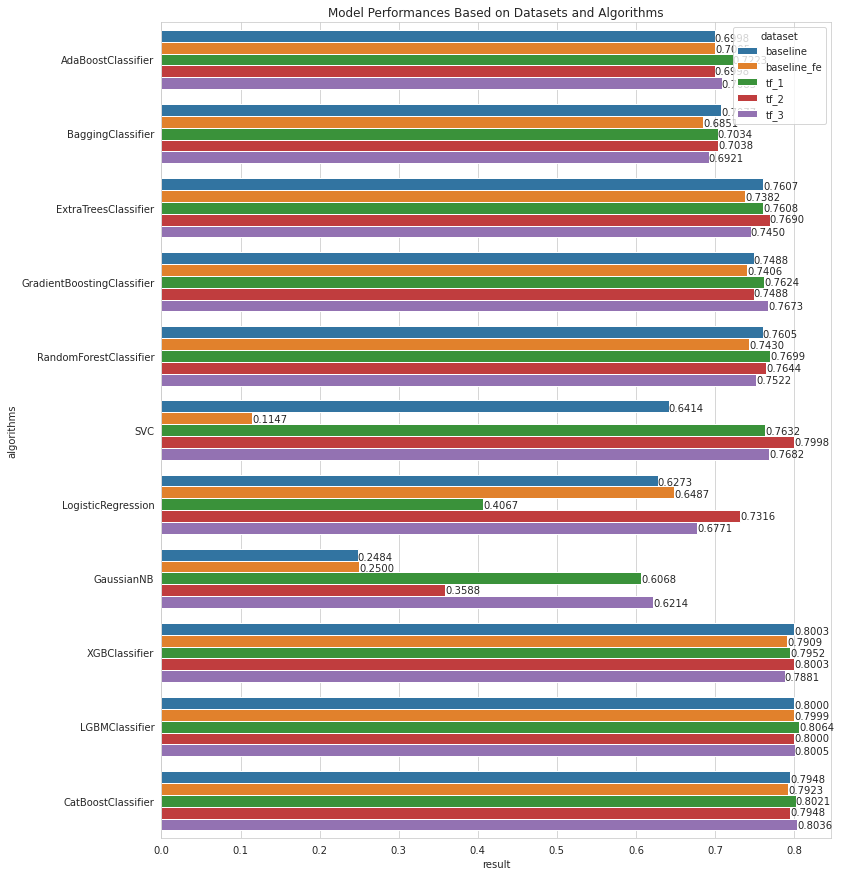

In [142]:
#cv_baseline_f1_1
#cv_baseline1_fe
#cv_tf1_f1
#cv_tf2_f1
#cv_tf3_f1
cv_result = pd.DataFrame({'dataset' : list(np.repeat('baseline', 11))+list(np.repeat('baseline_fe', 11))+list(np.repeat('tf_1', 11))+list(np.repeat('tf_2', 11))+list(np.repeat('tf_3', 11)),
                          'result' : cv_baseline_f1_1 + cv_baseline1_fe + cv_tf1_f1 + cv_tf2_f1 + cv_tf3_f1,
                          'algorithms' : algo*5})
plt.figure(figsize = [12, 15])
sns.barplot(data = cv_result,
            x = 'result',
            y = 'algorithms',
            hue = 'dataset')
plt.title('Model Performances Based on Datasets and Algorithms')
for index, value in enumerate(cv_result['result'].iloc[:11]) :
    plt.text(value, index-.25, '%.4f'%value)
    
for index, value in enumerate(cv_result['result'].iloc[11:22]) :
    plt.text(value, index-.1, '%.4f'%value)
    
for index, value in enumerate(cv_result['result'].iloc[22:33]) :
    plt.text(value, index+.05, '%.4f'%value)
    
for index, value in enumerate(cv_result['result'].iloc[33:44]) :
    plt.text(value, index+.2, '%.4f'%value)
    
for index, value in enumerate(cv_result['result'].iloc[44:]) :
    plt.text(value, index+.37, '%.4f'%value)

From the plot above, it's clear that CatBoostClassifier with TF-3 dataset has the best F1 score from 10 folds cross validation. Hence, that combination is selected in order to produce predictive model.

In [127]:
train_tf_3_train = pd.concat([x_train_train1.iloc[:, 1:39].reset_index(drop = True),
                            x_train_train1['total_words'].reset_index(drop = True),
                            x_train_train1['Result'].reset_index(drop = True)],
                           axis = 1)

train_tf_3_val = pd.concat([x_train_validation1.iloc[:, 1:39].reset_index(drop = True),
                            x_train_validation1['total_words'].reset_index(drop = True),
                            x_train_validation1['Result'].reset_index(drop = True)],
                           axis = 1)
train_tf_3_train['max_term'] = train_tf_3_train.iloc[:, 1:38].max(axis = 1)
train_tf_3_val['max_term'] = train_tf_3_val.iloc[:, 1:38].max(axis = 1)

for col in tqdm(train_tf_3_train.columns[:-2]) :
    train_tf_3_train[col] = 0.5 + (0.5*train_tf_3_train[col]/train_tf_3_train['max_term'])
#train_tf_3_train.head()

for col in tqdm(train_tf_3_val.columns[:-2]) :
    train_tf_3_val[col] = 0.5 + (0.5*train_tf_3_val[col]/train_tf_3_val['max_term'])
#train_tf_3_val.head()

In [133]:
model = CatBoostClassifier(random_state = 2,
                           verbose = False)
model.fit(train_tf_3_train.drop(columns = ['total_words', 'Result', 'max_term']),
          train_tf_3_train['Result'])
pred = model.predict(train_tf_3_val.drop(columns = ['total_words', 'Result', 'max_term']))
print(accuracy_score(np.array(pred), np.array(train_tf_3_val['Result'])))
print(f1_score(np.array(pred), np.array(train_tf_3_val['Result'])))
confusion_matrix(np.array(pred), np.array(train_tf_3_val['Result']))

0.8908418131359852
0.8


array([[727,  73],
       [ 45, 236]])

In [172]:
model = CatBoostClassifier(random_state = 2,
                           verbose = False)
model.fit(train_tf_3.iloc[:, 0:38],
          train_tf_3['Result'])
pred = model.predict(test_tf_3.iloc[:, 0:38])
result_csv = pd.DataFrame({'id' : [int(row) for row in test['id']],
                           'Result' : [int(row) for row in pred]})

([<matplotlib.axis.XTick at 0x7f390a16d410>,
 [Text(0, 0, 'spam'), Text(0, 0, 'non spam')])

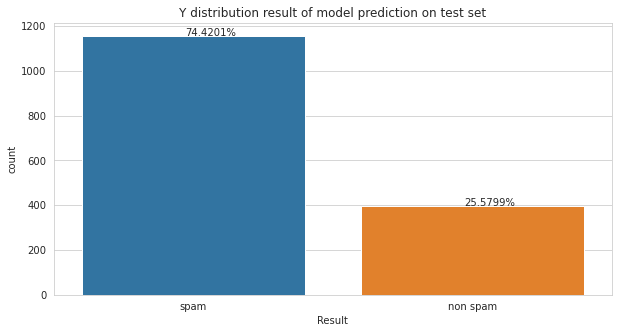

In [186]:
plt.figure(figsize = [10, 5])
sns.countplot(result_csv['Result'])
values = [result_csv[result_csv['Result'] == 0].shape[0]/result_csv.shape[0],
          result_csv[result_csv['Result'] == 1].shape[0]/result_csv.shape[0]]
for index, value in enumerate(values) :
    plt.text(index-.07, value*result_csv.shape[0], '%.4f'%(value*100) +'%')
plt.title('Y distribution result of model prediction on test set')
plt.xticks([0,1], ['spam', 'non spam'])